In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
import json
from collections import Counter
import pickle

In [2]:
seedcount = 42

In [3]:
#function to set the random seed for experiments, to aid in reproducibility
def seed_everything(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    
seed_everything(seedcount)
seedcount+=1

# Skew@K

In [4]:
#Function to measure the skew@k
def skewk(rankedlist, prob, attr, k): 
    count = 0
    epsilon = 0.000001
    for item in rankedlist[:k]:
        if item['real_attr']==attr:
            count+=1
    frac_ranked = count/k
    countall = 0
#     for item in rankedlist:
#         if item['attr']==attr:
#             countall+=1
    frac_real = prob[attr]
    return (frac_ranked+epsilon)/(frac_real+epsilon) #Removed math.log

# NDKL

In [5]:
def KL(p, q):
    """ Computes Kullback-Leibler divergence between two distributions.
    Both p and q must be dictionaries from events to probabilities.
    The divergence is defined only when q[event] == 0 implies p[event] == 0.
    """
    KL = 0
    epsilon = 1e-10
    for i in p:
        if p[i]>0:
            KL+= p[i] * math.log((p[i]+epsilon)/(q[i]+epsilon))
        else:
            KL+=0
    return KL

In [6]:
#function to measure normalized discounted KL divergence
def NDKL(tau,q):
    Z = sum(1/math.log2(i+1) for i in range(1,len(tau)+1))
    DKL = 0
    #q = getdist(tau)
    for k in range(1,len(tau)+1):
        p = getdist(tau[:k])
        DKL+= (1/math.log2(k+1))*KL(p,q)
    return DKL/Z

# NDCG

In [7]:
#Discounted Cumulative Gain
def DCG(R, k, method=0):
    r = [i['score'] for i in R]
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.

#Normalized DCG
def NDCG(r, k, method=0):
    dcg_max = DCG(sorted(r, key = lambda i: i['score'],reverse=True), k, method)
    if not dcg_max:
        return 0.
    return DCG(r, k, method) / dcg_max

In [8]:
def getdist(p):  
    # Given a list, return the true protected attr dist as a dictionary 
    d = {}
    for person in p:
        if person['real_attr'] not in d:
            d[person['real_attr']]=1
        else:
            d[person['real_attr']]+=1
    for attr in d:
        d[attr] = d[attr]/len(p)
    return d

In [9]:
def getdist_mispredicted(p):  
    # Given a list, return the predicted protected attr dist as a dictionary 
    d = {}
    for person in p:
        if person['attr'] not in d:
            d[person['attr']]=1
        else:
            d[person['attr']]+=1
    for attr in d:
        d[attr] = d[attr]/len(p)
    return d

In [10]:
def getskews(rankedlist,prob):
    #get skews for all the protected attrs in ranked list as a dictionary
    skew_dic = {}
    atts = set([])
    for item in rankedlist:
        atts.add(item['real_attr'])# attr
    
    for attr in atts:
        skew_dic[attr] = skewk(rankedlist,prob,attr,len(rankedlist))

    return skew_dic
    
def get_score(rankedlist): 
     #get utility scores for all the protected attrs in ranked list as a dictionary
    score_dic = {}
    for item in rankedlist:

        if item['real_attr']+'_list' not in score_dic:
            score_dic[item['real_attr']+'_list'] = []
        score_dic[item['real_attr']+'_list'].append(item['score'])
        
    score_dic2 = {}
        
    for attl in score_dic:
        attr = attl[:-5]
        score_dic2[attr] = np.mean(score_dic[attl])
    
    return score_dic2


def get_attention(rankedlist, dist = 'log', p = -1):
    #get mean attention values for all the protected attrs in ranked list as a dictionary
    sns.set(font_scale=1.5)
    base_attention = 100
    i = 1
    att_dic = {}
    for item in rankedlist:
        if dist == 'log':
            attention = base_attention/math.log2(i+1)
        elif dist == 'geometric':
            if p== -1:
                print('Error, set p = fraction of attention for the first result')
                return
            else:
                attention = base_attention*((1 - p)**(i-1))*p
        else:
            print('Error, dist must be log or geometric')

        if item['real_attr']+'_list'  not in att_dic:
            att_dic[item['real_attr']+'_list'] = []
        att_dic[item['real_attr']+'_list'].append(attention)
        i+=1
    
    
    att_dic2 = {}                                      
   
    for attl in att_dic:
        attr = attl[:-5]
        if dist == 'geometric':
            att_dic2[attr] = np.mean(att_dic[attl])
        else:
            att_dic2[attr] = np.mean(att_dic[attl])
    
    return att_dic2

def get_attention_list(rankedlist, dist = 'log', p = -1):
    #get attention values for every single person in ranked list as a nested dictionary of lists
    sns.set(font_scale=1.5)
    base_attention = 100
    i = 1
    att_dic = {}
    for item in rankedlist:
        if dist == 'log':
            attention = base_attention/math.log2(i+1)
        elif dist == 'geometric':
            if p== -1:
                print('Error, set p = fraction of attention for the first result')
                return
            else:
                attention = base_attention*((1 - p)**(i-1))*p
        else:
            print('Error, dist must be log or geometric')

        if item['real_attr']  not in att_dic:
            att_dic[item['real_attr']] = []
        att_dic[item['real_attr']].append(attention)
        i+=1
    
    return att_dic

def get_rankdelta(rankedlist): 
    #get max abs rank change values for all the protected attrs in ranked list as a dictionary
    rankdelta_dic = {}
    for item in rankedlist:

        if item['real_attr']+'_list' not in rankdelta_dic:
            rankdelta_dic[item['real_attr']+'_list'] = []
        rankdelta_dic[item['real_attr']+'_list'].append(abs(item['real_rank']-item['rank']))
        
    rankdelta_dic2 = {}
        
    for attl in rankdelta_dic:
        attr = attl[:-5]
        rankdelta_dic2[attr] = np.mean(rankdelta_dic[attl])
    
    return rankdelta_dic2

def get_rankdelta_list(rankedlist): 
    #get rank change values for every single person in ranked list as a nested dictionary of lists
    rankdelta_dic = {}
    for item in rankedlist:

        if item['real_attr'] not in rankdelta_dic:
            rankdelta_dic[item['real_attr']] = []
        rankdelta_dic[item['real_attr']].append(item['real_rank']-item['rank'])
    
    return rankdelta_dic

# DetConsSort Implementation

In [11]:
from collections import defaultdict as ddict
import operator


def swap(temp_list, pos_i, pos_j):
    temp = temp_list[pos_i]
    temp_list[pos_i] = temp_list[pos_j]
    temp_list[pos_j] = temp

def det_const_sort(score_dict, prob, kmax):
    
    scoreList             = [(elem['attr'], elem['score'], elem['real_attr'],elem['rank'],elem['real_rank']) for elem in score_dict]
    AttrList              = list(set([elem[0] for elem in scoreList]))
    AttrScores            = {}
    AttrCount             = {}
    minAttrCount          = {}
    GlobalAttrCounts      = {}
    rankedAttrList        = {} #[]
    rankedScoreList       = {} #[]
    maxIndices            = {} #[]
    lastEmpty             =  0
    k                     =  0
    
    for i, attr in enumerate(AttrList):
        AttrCount[attr]        = 0
        minAttrCount[attr]     = 0
        GlobalAttrCounts[attr] = sum([1 for elem in scoreList if elem[0]==attr])
        AttrScores[attr]       = [(elem[1],elem[2],elem[3],elem[4]) for elem in scoreList if elem[0]==attr] # to be initialized 
        
    while lastEmpty       <= kmax:        
        
        if lastEmpty == len(scoreList):
            break
        
        k+=1
        tempMinAttrCount  = ddict(int)
        changedMins       = {}
        for attr in AttrList:
            tempMinAttrCount[attr] = math.floor(k*prob[attr])
            if minAttrCount[attr] < tempMinAttrCount[attr] and minAttrCount[attr] < GlobalAttrCounts[attr]:
                changedMins[attr]  = AttrScores[attr][AttrCount[attr]]
                    
        if len(changedMins) !=0:
            ordChangedMins  = sorted(changedMins.items(), key= lambda x: x[1][0], reverse= True)
            for elem in ordChangedMins:
                rankedAttrList[lastEmpty] = elem[0]
                rankedScoreList[lastEmpty]= AttrScores[elem[0]][AttrCount[elem[0]]] # (score, real_attr)
                maxIndices[lastEmpty]     = k
                start                     = lastEmpty
                while start > 0 and maxIndices[start-1] >= start and rankedScoreList[start-1][0]< rankedScoreList[start][0]:                
                    swap(rankedScoreList, start-1, start)
                    swap(maxIndices, start-1, start)
                    swap(rankedAttrList, start-1, start)
                    start -= 1
                AttrCount[elem[0]]+=1
                lastEmpty+=1
            minAttrCount= dict(tempMinAttrCount)
        
    
    newRankList = []
    
    rankedAttrArr  = [rankedAttrList[i] for i in sorted(rankedAttrList)]
    rankedScoreArr = [rankedScoreList[i] for i in sorted(rankedScoreList)]
    k = 1
    for attr, score in zip(rankedAttrArr, rankedScoreArr ):
        newRankList.append({'attr':attr, 'score':score[0], 'real_attr': score[1],'rank':k, 'real_rank': score[3]})
        k+=1
        
    return newRankList

# Simulate

In [12]:
#generate random probabilities for a given list of attributes
def genprob(attrlist):
    prob = {}
    s = 0
    for attr in attrlist:
        p = np.random.uniform(0,1)
        s+=p
        prob[attr]=p
    for attr in attrlist:
        prob[attr]/=s
    return prob

In [13]:
#generate a random list of candidates given a fixed attribute distribution with random scores
def getcandidates(prob):
    elements = list(prob.keys())
    candidates = []
    for e in elements:
        for n in range(1000):#(int(k/len(elements))):
            candidates.append(e)
    clist = []
    idn = 1
    for c in candidates:
        cand = {}
        cand['id']= str(idn)
        idn+=1
        cand['attr']= c
        cand['real_attr']= c
        cand['score']=np.random.uniform(0,1)
        clist.append(cand)
    clist.sort(key = lambda i: i['score'],reverse=True)
    idn = 1
    for c in clist:
        c['rank'] = idn
        c['real_rank'] = idn
    return clist

In [14]:
#randomly mispredict the ground truth attribute values in the list
def randomize(oglist, acc):
    attrs = set([i['real_attr'] for i in oglist])
    newlist = []
    for item in oglist:
        if random.random() < acc: #True
            item['attr']=item['real_attr']
        else:
            item['attr']=random.choice(list(attrs - set(item['real_attr'])))
        newlist.append(item)
    return newlist

In [15]:
#simulation loop to randomly mispredict generated lists according to varying accuracies
def simulate_err(prob):

    dlist = []
    
    print('Distribution: ', prob,'\n')
    score_dict = getcandidates(prob)

    k = 300

    print('Simulating original protected categories')

    vanilla_NDKL = []
    algo_NDKL = []
    vanilla_attention = []
    algo_attention = []
    vanilla_NDCG = []
    algo_NDCG = []




    for acc in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:

        print('Simulating accuracy: ', acc)


        vanilla_NDKL = []
        algo_NDKL = []
        vanilla_attention = []
        algo_attention = []
        vanilla_NDCG = []
        algo_NDCG = []
        vanilla_rankdelta = []
        algo_rankdelta = []

        for i in range(100):
            global seedcount
            seed_everything(seedcount)
            seedcount+=1

            score_dict_rand = randomize(score_dict,acc)

            vanilla_NDKL.append(NDKL(score_dict_rand[:k],prob))
            vanilla_NDCG.append(NDCG(score_dict_rand[:k],k))
            a = det_const_sort(score_dict_rand,prob,k)
            
            algo_NDKL.append(NDKL(a,prob))
            algo_NDCG.append(NDCG(a,k))
            vattd = get_attention(score_dict_rand[:k],dist = 'geometric',p=0.015)
            vanilla_attention.append(min(vattd.values())/max(vattd.values()))
            vscore = get_score(score_dict_rand[:k])

            aattd = get_attention(a,dist = 'geometric',p=0.015)
            algo_attention.append(min(aattd.values())/max(aattd.values()))
            
            rankdelta = get_rankdelta(score_dict_rand[:k])
            algo_rankdelta_d = get_rankdelta(a)
            #print(algo_rankdelta_d)
            vanilla_rankdelta.append(abs(max(rankdelta.values(),key=abs)))
            algo_rankdelta.append(abs(max(algo_rankdelta_d.values(),key=abs)))
#             vanilla_rankdelta.append(np.mean(list(rankdelta.values())))
#             algo_rankdelta.append(np.mean(list(algo_rankdelta_d.values())))







        dlist.append([acc,np.mean(vanilla_NDKL), np.mean(algo_NDKL), np.mean(vanilla_attention)
                     , np.mean(algo_attention),np.mean(vanilla_NDCG), np.mean(algo_NDCG), 
                      np.mean(vanilla_rankdelta), np.mean(algo_rankdelta)])
                         

    
    
    df = pd.DataFrame(dlist, columns = ['Accuracy','Vanilla_NDKL','Algo_NDKL', 'Vanilla_attention_biasratio',
                                       'Algo_attention_biasratio','Vanilla_NDCG','Algo_NDCG',
                                        'Vanilla_rankdelta','Algo_rankdelta'])

    print('\n\nmean over 100 simulations')

    return df

In [16]:
def show(df):
    cols = ['Accuracy',
     'Algo_NDKL',
     'Algo_attention_biasratio',
     'Algo_NDCG',
     'Algo_rankdelta']

    display(df[cols])

# Accuracy vs Fairness - synthetic data
### A - F are 6 dataframes for the 6 different simulations

In [17]:
dfA = simulate_err({"White":0.33,"Black":0.33,"Asian":0.33})
row1 = dfA.to_dict(orient='index')
for i in row1[0]:
    if 'Vanilla' in i:
        print(i,row1[0][i])

Distribution:  {'White': 0.33, 'Black': 0.33, 'Asian': 0.33} 

Simulating original protected categories
Simulating accuracy:  0.1
Simulating accuracy:  0.2
Simulating accuracy:  0.3
Simulating accuracy:  0.4
Simulating accuracy:  0.5
Simulating accuracy:  0.6
Simulating accuracy:  0.7
Simulating accuracy:  0.8
Simulating accuracy:  0.9
Simulating accuracy:  1.0


mean over 100 simulations
Vanilla_NDKL 0.08010918004971064
Vanilla_attention_biasratio 0.6586181472461774
Vanilla_NDCG 1.0
Vanilla_rankdelta 0.0


In [18]:
dfB = simulate_err({"White":0.2,"Black":0.3,"Asian":0.5})
row1 = dfB.to_dict(orient='index')
for i in row1[0]:
    if 'Vanilla' in i:
        print(i,row1[0][i])

Distribution:  {'White': 0.2, 'Black': 0.3, 'Asian': 0.5} 

Simulating original protected categories
Simulating accuracy:  0.1
Simulating accuracy:  0.2
Simulating accuracy:  0.3
Simulating accuracy:  0.4
Simulating accuracy:  0.5
Simulating accuracy:  0.6
Simulating accuracy:  0.7
Simulating accuracy:  0.8
Simulating accuracy:  0.9
Simulating accuracy:  1.0


mean over 100 simulations
Vanilla_NDKL 0.07828989036085077
Vanilla_attention_biasratio 0.7063573871385782
Vanilla_NDCG 1.0
Vanilla_rankdelta 0.0


In [19]:
dfC = simulate_err({"White":0.1,"Black":0.3,"Asian":0.6})
row1 = dfC.to_dict(orient='index')
for i in row1[0]:
    if 'Vanilla' in i:
        print(i,row1[0][i])

Distribution:  {'White': 0.1, 'Black': 0.3, 'Asian': 0.6} 

Simulating original protected categories
Simulating accuracy:  0.1
Simulating accuracy:  0.2
Simulating accuracy:  0.3
Simulating accuracy:  0.4
Simulating accuracy:  0.5
Simulating accuracy:  0.6
Simulating accuracy:  0.7
Simulating accuracy:  0.8
Simulating accuracy:  0.9
Simulating accuracy:  1.0


mean over 100 simulations
Vanilla_NDKL 0.29703865101624605
Vanilla_attention_biasratio 0.8590583625331425
Vanilla_NDCG 1.0
Vanilla_rankdelta 0.0


In [20]:
dfD = simulate_err({"White":0.1,"Black":0.2,"Asian":0.7})
row1 = dfD.to_dict(orient='index')
for i in row1[0]:
    if 'Vanilla' in i:
        print(i,row1[0][i])

Distribution:  {'White': 0.1, 'Black': 0.2, 'Asian': 0.7} 

Simulating original protected categories
Simulating accuracy:  0.1
Simulating accuracy:  0.2
Simulating accuracy:  0.3
Simulating accuracy:  0.4
Simulating accuracy:  0.5
Simulating accuracy:  0.6
Simulating accuracy:  0.7
Simulating accuracy:  0.8
Simulating accuracy:  0.9
Simulating accuracy:  1.0


mean over 100 simulations
Vanilla_NDKL 0.3716861696312187
Vanilla_attention_biasratio 0.9080853755915664
Vanilla_NDCG 1.0
Vanilla_rankdelta 0.0


In [21]:
dfE = simulate_err({"White":0.25,"Black":0.25,"Asian":0.25, "Latino":0.25})
row1 = dfE.to_dict(orient='index')
for i in row1[0]:
    if 'Vanilla' in i:
        print(i,row1[0][i])

Distribution:  {'White': 0.25, 'Black': 0.25, 'Asian': 0.25, 'Latino': 0.25} 

Simulating original protected categories
Simulating accuracy:  0.1
Simulating accuracy:  0.2
Simulating accuracy:  0.3
Simulating accuracy:  0.4
Simulating accuracy:  0.5
Simulating accuracy:  0.6
Simulating accuracy:  0.7
Simulating accuracy:  0.8
Simulating accuracy:  0.9
Simulating accuracy:  1.0


mean over 100 simulations
Vanilla_NDKL 0.10451577831466925
Vanilla_attention_biasratio 0.599433925849153
Vanilla_NDCG 1.0
Vanilla_rankdelta 0.0


In [22]:
dfF = simulate_err({"White":0.1,"Black":0.2,"Asian":0.6, "Latino":0.1})
row1 = dfF.to_dict(orient='index')
for i in row1[0]:
    if 'Vanilla' in i:
        print(i,row1[0][i])

Distribution:  {'White': 0.1, 'Black': 0.2, 'Asian': 0.6, 'Latino': 0.1} 

Simulating original protected categories
Simulating accuracy:  0.1
Simulating accuracy:  0.2
Simulating accuracy:  0.3
Simulating accuracy:  0.4
Simulating accuracy:  0.5
Simulating accuracy:  0.6
Simulating accuracy:  0.7
Simulating accuracy:  0.8
Simulating accuracy:  0.9
Simulating accuracy:  1.0


mean over 100 simulations
Vanilla_NDKL 0.40109149139679945
Vanilla_attention_biasratio 0.7141633677433548
Vanilla_NDCG 1.0
Vanilla_rankdelta 0.0


# Plot

In [23]:
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

In [24]:
color_list = ['red','orange','burlywood', 'blue', 'deepskyblue', 'forestgreen', 'mediumseagreen', 'deeppink','orchid']

In [25]:
#function to plot the line charts of the simulations
def simplot(colname,label,filename,onlylegend = False):
    toplot = colname
    cols = ['Accuracy',
     'Algo_NDKL',
     'Algo_attention_biasratio',
     'Algo_NDCG',
     'Algo_rankdelta']

    plt.rcParams['axes.edgecolor'] = "#cccccc"
    if onlylegend==False:
        if 'ndcg' in filename:
            plt.rcParams["figure.figsize"] = (6/1.1,5.8/1.1)
        else:
            plt.rcParams["figure.figsize"] = (6,5)
            
    plt.rcParams["font.family"] = 'DejaVu Serif'
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 1
    plt.rcParams['grid.color'] = "#cccccc"
    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams["ps.fonttype"] = 42

    ax = dfA[cols].plot(x='Accuracy',y=toplot,color=color_list[1],marker='o')

    ax.xaxis.grid(True,which='both')
    ax.yaxis.grid(True,which='both')


    ax.set_facecolor('white')
    ax.tick_params(axis='y', which='both',labelsize=16)
    ax.tick_params(axis='x', which='both',labelsize=16)
    ax.xaxis.set_minor_formatter(ScalarFormatter())
    ax.xaxis.set_major_formatter(ScalarFormatter())
    
    if 'rankdelta' in filename:
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
        ax.yaxis.set_minor_formatter(ticker.FormatStrFormatter('%0.0f'))
    elif 'ndcg' in filename:
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.4f'))
        ax.yaxis.set_minor_formatter(ticker.FormatStrFormatter('%0.4f'))
    else:
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
        ax.yaxis.set_minor_formatter(ticker.FormatStrFormatter('%0.2f'))


    dfB[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[4],marker='*')
    dfC[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[6],marker='+')
    dfD[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[8],marker='^')
    dfE[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[3],marker='<')
    dfF[cols].plot(x='Accuracy',y=toplot, ax = ax,color=color_list[0],marker='>')


    plt.ylabel(label,fontsize=20,weight='bold')
    plt.xlabel('Accuracy', fontsize =20,weight='bold')

    plt.xticks(np.arange(0, 1.2, 0.2))


    ax.get_legend().remove()
    
    if onlylegend:
        handles, l = ax.get_legend_handles_labels()
        labels = ['Dist. A', 'Dist. B', 'Dist. C', 'Dist. D', 'Dist. E','Dist. F']
        ax.clear()
        plt.clf()
        plt.cla()
        plt.close()

        legend = plt.legend(handles, labels, loc=3, framealpha=1, 
                            frameon=True,ncol=len(handles),facecolor='white', prop = {'weight':'bold', 'size': 20})
        plt.gca().set_axis_off()
        plt.gca().set_facecolor('white')
        
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())


        def export_legend(legend, filename=filename, expand=[-5,-5,5,5]):
            fig  = legend.figure
            fig.canvas.draw()
            plt.tight_layout()
            bbox  = legend.get_window_extent()
            bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
            bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
            plt.savefig('Plots/'+filename, bbox_inches = "tight",pad_inches = 0)

        export_legend(legend)
        #plt.show()

    plt.savefig('Plots/'+filename, pad_inches = 0,bbox_inches = "tight")

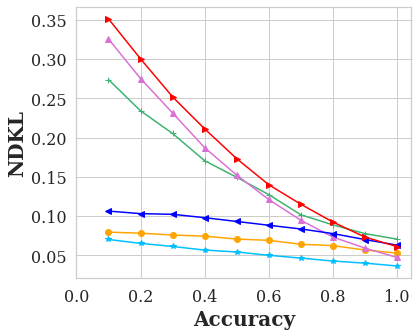

In [26]:
simplot('Algo_NDKL','NDKL','simulation_ndkl.pdf')

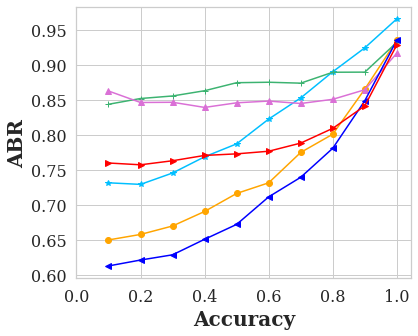

In [27]:
simplot('Algo_attention_biasratio','ABR','simulation_abr.pdf')

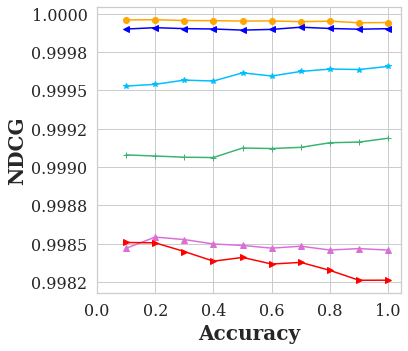

In [28]:
simplot('Algo_NDCG','NDCG','simulation_ndcg.pdf')

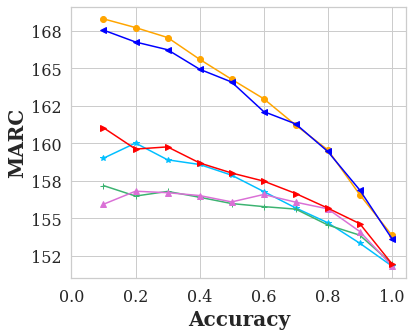

In [29]:
simplot('Algo_rankdelta','MARC','simulation_rankdelta.pdf')

/home/avijit/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


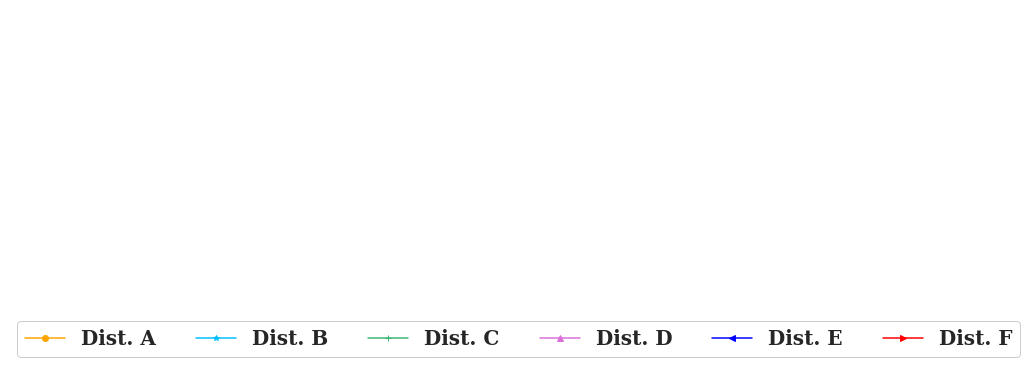

In [30]:
simplot('Algo_rankdelta','Max. Absolute Rank Change','simulation_legend.pdf',onlylegend=True)

# Case studies

In [31]:
#function to plot overall metrics
def smallplot(LL,color,filename):
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 1
    plt.rcParams['grid.color'] = "#cccccc"
    plt.rcParams['axes.edgecolor'] = "#cccccc"
    plt.rcParams["figure.figsize"] = (4.5,2.25)
    plt.rcParams["font.family"] = 'DejaVu Serif'
    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams["ps.fonttype"] = 42


    plt.bar(LL.keys(), LL.values(),color=color,width = 0.4)
    ax = plt.gca()
    ax.set_facecolor('white')
    # ax.get_legend().remove()
    ax.xaxis.grid(False)
    ax.yaxis.grid(True,which='both')
    if 'NDCG' in filename:
        ax.set_ylim([min(LL.values())-0.005,1.0])
    ax.tick_params(axis='y', which='both',labelsize=22)
    ax.tick_params(axis='x', which='both',labelsize=24)
    
    if 'rank' in filename:
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
        ax.yaxis.set_minor_formatter(ticker.FormatStrFormatter('%0.0f'))
    else:
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))
        ax.yaxis.set_minor_formatter(ticker.FormatStrFormatter('%0.2f'))
    if 'NDCG' in filename:
        pass
#         plt.yticks(np.arange(0, max(LL.values()), (max(LL.values()) - 0)/4))
#         plt.yticks(np.arange(min(LL.values()), max(LL.values()), (max(LL.values()) - min(LL.values()))/4))
    else:
        plt.yticks(np.arange(0, max(LL.values()), (max(LL.values()) - 0)/4))


    plt.xlabel(None)
    
    plt.xticks(rotation=90,weight='bold')
    for spine in ('top', 'right'): # 'bottom', 'left'): 
        ax.spines[spine].set_visible(False)

    plt.savefig('Plots/'+filename, bbox_inches = 'tight')

    #print((pd.DataFrame([LL]).T).to_latex())

In [32]:
cats = ['White_Male', 'White_Female', 'Black_Male', 'Black_Female', 'Hispanic_Male', 'Hispanic_Female', 'Asian_Male', 'Asian_Female']
color_list = ['orange','burlywood', 'blue', 'deepskyblue', 'forestgreen', 'mediumseagreen', 'deeppink','orchid']
d2c = dict(zip(cats, color_list))
map(d2c.get,sorted(list(['White_Male', 'White_Female', 'Black_Male'])))

In [33]:
#function to plot groupwise metrics
def largeplot(LL,label,filename):
    cats = ['White_Male', 'White_Female', 'Black_Male', 'Black_Female', 'Hispanic_Male', 'Hispanic_Female', 'Asian_Male', 'Asian_Female']
    color_list = ['orange','burlywood', 'blue', 'deepskyblue', 'forestgreen', 'mediumseagreen', 'deeppink','orchid']
    d2c = dict(zip(cats, color_list))
    
    df = pd.DataFrame(LL)
    df.columns = method_names

    dft = df.T
    dftcol = dft.columns

    dft['X'] = dft.index

    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 1
    plt.rcParams['grid.color'] = "#cccccc"
    plt.rcParams['axes.edgecolor'] = "#cccccc"
    plt.rcParams["figure.figsize"] = (6,4)
    plt.rcParams["font.family"] = 'DejaVu Serif'
    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams["ps.fonttype"] = 42

    #plt.grid(True)
    width = 0.85
    if 'eq' in filename:
        width = 0.7

    ax = dft.plot(x="X", y=sorted(list(dftcol)),width = width, edgecolor='black',
                  linewidth=0.5,kind="bar",color=[d2c.get(cl) for cl in sorted(list(dftcol))])
    ax.set_facecolor('white')
    ax.get_legend().remove()
    ax.xaxis.grid(False)
    ax.yaxis.grid(True,which='both')
    ax.tick_params(axis='y', which='both',labelsize=13)
    ax.tick_params(axis='x', which='both',labelsize=13)


    #plt.legend(loc=(1.04,0))
    plt.ylabel(label,size=13,weight='bold')
    plt.xlabel(None)
    plt.xticks(rotation=90,weight='bold')
    for spine in ('top', 'right'): # 'bottom', 'left'): 
        plt.gca().spines[spine].set_visible(False)






    # plt.ylabel("Population Skew")
    plt.savefig('Plots/'+filename, bbox_inches = 'tight')

In [34]:
#function to plot groupwise+individual metrics
def boxplot(LL,label,filename,log=False):
    cats = ['White_Male', 'White_Female', 'Black_Male', 'Black_Female', 'Hispanic_Male', 'Hispanic_Female', 'Asian_Male', 'Asian_Female']
    color_list = ['orange','burlywood', 'blue', 'deepskyblue', 'forestgreen', 'mediumseagreen', 'deeppink','orchid']
    d2c = dict(zip(cats, color_list))
    
    dl = []
    for c in LL:
        for k in LL[c]:
            for t in LL[c][k]:
                dl.append({"Algorithm":c,"Subgroup":k,"Measure":t})

    
    
    df = pd.DataFrame(dl)
    dfcats = set(df.Subgroup)
    


    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 1
    plt.rcParams['grid.color'] = "#cccccc"
    plt.rcParams['axes.edgecolor'] = "#cccccc"
    plt.rcParams["figure.figsize"] = (6,4)
    plt.rcParams["font.family"] = 'DejaVu Serif'
    plt.rcParams["pdf.fonttype"] = 42
    plt.rcParams["ps.fonttype"] = 42

    #plt.grid(True)
    width = 0.85
    if 'eq' in filename:
        width = 0.7
    
    ax = sns.boxplot(y='Measure', 
                     x='Algorithm', 
                     data=df, 
                     hue='Subgroup',
                     saturation=1,
                     linewidth=0.7,
                     width = width,
                     showfliers=False,
                     showmeans=True,
                     meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"5"},
                     hue_order = sorted(list(dfcats)),
                     palette=map(d2c.get,sorted(list(dfcats))))

    ax.set_facecolor('white')
    ax.get_legend().remove()
    ax.xaxis.grid(False)
    if log == True:
        ax.set(yscale="symlog")
    ax.yaxis.grid(True,which='both')
    ax.tick_params(axis='y', which='both',labelsize=13)
    ax.tick_params(axis='x', which='both',labelsize=13)


    #plt.legend(loc=(1.04,0))
    plt.ylabel(label,size=13,weight='bold')
    plt.xlabel(None)
    plt.xticks(rotation=90,weight='bold')
    for spine in ('top', 'right'): # 'bottom', 'left'): 
        plt.gca().spines[spine].set_visible(False)


    # plt.ylabel("Population Skew")
    plt.savefig('Plots/'+filename, bbox_inches = 'tight')

### nameprism utility

In [35]:
npdic = pickle.load(open('nameprism_preds.p','rb'))
def getnameprismrace(name):
    for item in npdic:
        if item['name'].strip().lower() == name.strip().lower():
            mx = 0
            pr = ""
            for i in item['pred_race']:
                if item['pred_race'][i] > mx and i not in ['2PRACE','AIAN']:
                    mx = item['pred_race'][i]
                    pr = i
            return pr
    return "err"

In [36]:
#npdic

## Chess

In [37]:
K = 300

In [38]:
chessdf = pd.read_csv('CHESS/chessrankings.csv')

In [39]:
chesslist_base = []

In [40]:
chesslabels_maj = json.load(open('CHESS/chesslabels_majority.json'))

In [41]:
def getrace(fid):
    if str(fid) not in chesslabels_maj:
        return "err"
    rc = chesslabels_maj[str(fid)]
    if rc == 'White/Caucasian (Non hispanic)':
        return 'White'
    elif rc == 'Asian (Far East, Southeast Asia, and the Indian subcontinent)':
        return 'Asian'
    elif rc == 'Hispanic/Latino':
        return 'Hispanic'
    elif rc == 'Black/African':
        return 'Black'
    else:
        return "err"
    

In [42]:
#remove groups with less than 1% representation
chessdf['race'] = chessdf['fideid'].apply(getrace)
chessdf = chessdf[chessdf['race']!='err']
chessdf['Grp'] = chessdf['race'].astype(str)+'_'+chessdf['sex'].astype(str)
tbr = []
cnt = Counter(chessdf['Grp'])
for g in cnt:
#     if (1/K)/(cnt[g]/len(chessdf))>1.5:
    if (cnt[g]/len(chessdf))<0.01:
        tbr.append(g)
print(tbr)
chessdf = chessdf[~chessdf['Grp'].isin(tbr)]

['Black_M', 'Hispanic_F', 'Black_F']


In [43]:
chessrank_base = []
for i,row in chessdf.iterrows():
    g = ""
    if row['sex']=='M':
        g="Male"
    else:
        g="Female"
    chessrank_base.append({'real_rank':i+1,'rank':i+1,'id':str(row['fideid']), 'attr':str(row['race'])+'_'+g,
                           'real_attr':str(row['race'])+'_'+g, 'score':int(row['rating'])})

In [44]:
len(chessrank_base)

3251

In [45]:
# Deepface

chessrank_deepface = []
temp = {}

f = open('CHESS/deepface.txt')
for line in f.readlines():
    items = line.split("\t")
    g = ""
    if items[1]=='Man':
        g = 'Male'
    else:
        g = 'Female'
    r = items[2][:-1]
    race = ""
    if r == "white" or r == "middle eastern":
        race = "White"
    if r == "latino hispanic":
        race = "Hispanic"
    if r == "asian" or r=="indian":
        race = "Asian"
    if r == "black":
        race = "Black"
    ui = items[0].split('/')[-1][:-4]
    temp[ui] = race+"_"+g
f.close()

for t in chessrank_base:
    entry = t.copy()
    if entry['id'] in temp:
        entry['attr'] = temp[entry['id']]
        chessrank_deepface.append(entry)

In [46]:
genderize = pd.read_csv('CHESS/genderize.csv')
genderizedict = {}
for i,j in zip(genderize.fideid,genderize.gender):
    if j in ['male','female']:
        genderizedict[str(i)]=str(j).title()

In [47]:
ethnicolor = pd.read_csv('CHESS/ethnicolor.csv')
ethnicolordict = {}
for i,j in zip(ethnicolor.fideid,ethnicolor.race):
    r = j
    if r == 'api':
        r = 'asian'
    ethnicolordict[str(i)]=str(r).title()

In [48]:
ethcnn = pd.read_csv('CHESS/ethcnn.csv')
ethcnndict = {}
for i,j in zip(ethcnn.fideid,ethcnn.ETHCNN_Pred):
    r = j.split('_')[0]
    if r == 'Caucasian':
        r = 'White'
    if r == 'African-American':
        r = 'Black'
    if r!='Native American':
        ethcnndict[str(i)]=str(r).title()

In [49]:
nameprismdict = {}
for i,row in chessdf.iterrows():
    r = getnameprismrace(row['name'])
    if r == 'API':
        r = 'Asian'
    nameprismdict[str(row['fideid'])]=r

In [50]:
chessrank_cnn_gen = []

for t in chessrank_base:
    entry = t.copy()
    if entry['id'] in ethcnndict and entry['id'] in genderizedict:
        entry['attr'] = ethcnndict[entry['id']]+'_'+genderizedict[entry['id']]
        chessrank_cnn_gen.append(entry)

In [51]:
chessrank_ethnicolor_gen = []

for t in chessrank_base:
    entry = t.copy()
    if entry['id'] in ethnicolordict and entry['id'] in genderizedict:
        entry['attr'] = ethnicolordict[entry['id']]+'_'+genderizedict[entry['id']]
        chessrank_ethnicolor_gen.append(entry)

In [52]:
chessrank_nameprism_gen = []

for t in chessrank_base:
    entry = t.copy()
    if entry['id'] in nameprismdict and entry['id'] in genderizedict:
        entry['attr'] = nameprismdict[entry['id']]+'_'+genderizedict[entry['id']]
        chessrank_nameprism_gen.append(entry)

In [53]:
chessdist = getdist(chessrank_base)
allat = {'Asian_Female',
 'Asian_Male',
 'Black_Female',
 'Black_Male',
 'Hispanic_Female',
 'Hispanic_Male',
 'White_Female',
 'White_Male'}
for a in allat:
    if a not in chessdist:
        chessdist[a] = 0

In [54]:
chess_detconst_oracle = det_const_sort(chessrank_base,chessdist,K)
chess_detconst_deepface = det_const_sort(chessrank_deepface,chessdist,K)
chess_detconst_cnn_gen = det_const_sort(chessrank_cnn_gen,chessdist,K)
chess_detconst_ethnicolor_gen = det_const_sort(chessrank_ethnicolor_gen,chessdist,K)
chess_detconst_nameprism_gen = det_const_sort(chessrank_nameprism_gen,chessdist,K)

In [55]:
# method_names = ['Baseline','Oracle','Cnn_Gen','EthniColr_Gen','Nameprism_Gen','DeepFace']
method_names = ['BASE','ORCL','CNNG','ECLG','NPMG','DPFC']
chessrankedlists = [chessrank_base,
               chess_detconst_oracle,
               chess_detconst_cnn_gen,
               chess_detconst_ethnicolor_gen,
               chess_detconst_nameprism_gen,
               chess_detconst_deepface]

In [56]:
chess_NDKL_dic = {}
chess_NDCG_dic = {}
chess_skew_dic = {}
chess_att_dic = {}
chess_att_dic_list = {}
chess_ABR_dic = {}
chess_rankdelta_dic = {}
chess_rankdelta_dic_list = {}


for method_name, rankedlist in zip(method_names, chessrankedlists):
    chess_NDKL_dic[method_name] = NDKL(rankedlist[:K], chessdist)
    chess_NDCG_dic[method_name] = NDCG(rankedlist[:K], K)
    chess_skew_dic[method_name] = getskews(rankedlist[:K],chessdist)
    ad = get_attention(rankedlist[:K],dist='geometric',p=0.015)
    chess_att_dic[method_name] = ad
    chess_ABR_dic[method_name] = min(ad.values())/max(ad.values())
    rd = get_rankdelta(rankedlist[:K])
    chess_rankdelta_dic[method_name] = abs(max(rd.values(),key=abs))
    chess_rankdelta_dic_list[method_name] = get_rankdelta_list(rankedlist[:K])
    chess_att_dic_list[method_name] = get_attention_list(rankedlist[:K],dist='geometric',p=0.015)

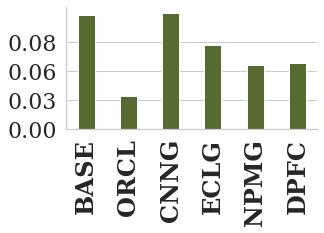

In [57]:
smallplot(chess_NDKL_dic,'darkolivegreen','chess_NDKL.pdf')

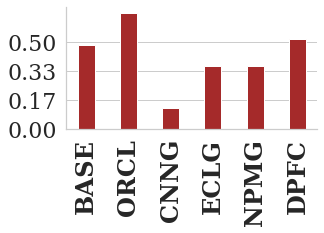

In [58]:
smallplot(chess_ABR_dic,'brown','chess_ABR.pdf')

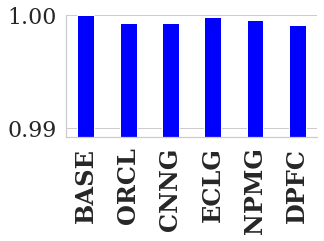

In [59]:
smallplot(chess_NDCG_dic,'blue','chess_NDCG.pdf')

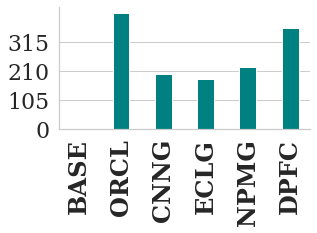

In [60]:
smallplot(chess_rankdelta_dic,'teal','chess_rankdelta.pdf')

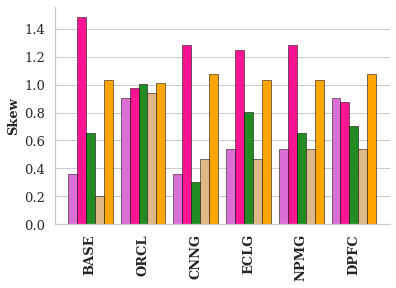

In [61]:
largeplot(chess_skew_dic,"Skew",'chess_skew.pdf')

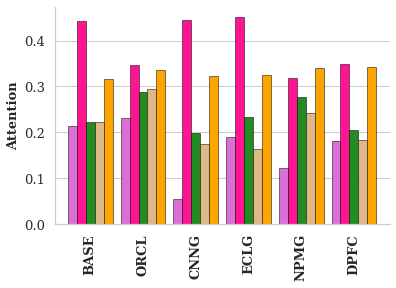

In [62]:
largeplot(chess_att_dic,"Attention",'chess_att.pdf')

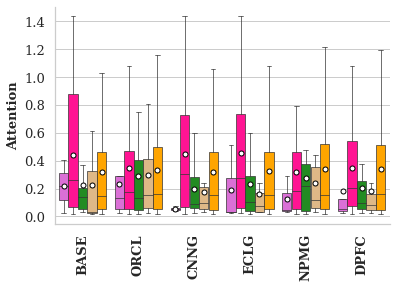

In [63]:
boxplot(chess_att_dic_list,"Attention",'chess_att_list.pdf',log=False)

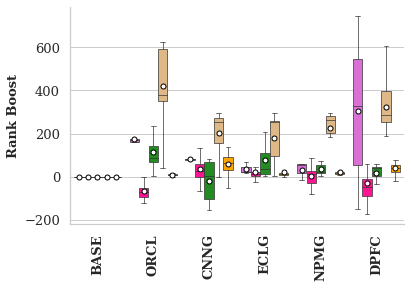

In [64]:
boxplot(chess_rankdelta_dic_list,"Rank Boost",'chess_rankdelta_list.pdf',log=False)

## Entrepreneurs

In [65]:
K = 300

In [66]:
entdf = pd.read_csv('ENTREPRENEURS/startupfounders_rankings.csv')

In [67]:
entdf

,Unnamed: 0,Foundername,ProfileURL,Inflation adjusted Amount,UID,image,gender
0,0,Robert Nelsen,https://www.crunchbase.com/person/robert-t-nelsen,7.673250e+08,6806685477691779243,True,Male
1,1,Steve Harr,https://www.crunchbase.com/person/steve-harr,7.000000e+08,3913211127155952344,True,Male
2,2,Noubar Afeyan,https://www.crunchbase.com/person/noubar-afeyan,7.000000e+08,6164919262500055633,True,Male
3,3,Hans Bishop,https://www.crunchbase.com/person/hans-bishop,7.000000e+08,6115182595565940268,True,Male
4,4,Mihir Shukla,https://www.crunchbase.com/person/mihir-shukla,5.613144e+08,9146463270169778525,True,Male
...,...,...,...,...,...,...,...
3447,3675,Ajay Kori,https://www.crunchbase.com/person/ajay-kori,1.361020e+07,560301497384527103,True,Male
3448,3676,Scott Simpson,https://www.crunchbase.com/person/scott-simpson-3,1.361020e+07,7183528110950826255,True,Male
3449,3677,Chetan Shenoy,https://www.crunchbase.com/person/chetan-shenoy,1.361020e+07,2783675130911054606,True,Male
3450,3678,Tim Brunk,https://www.crunchbase.com/person/tim-brunk,1.360000e+07,6190350526114060641,True,Male


In [68]:
entlist_base = []

In [69]:
entlabels_maj = json.load(open('ENTREPRENEURS/entlabels_majority.json'))

In [70]:
def getrace_ent(fid):
    if str(fid) not in entlabels_maj:
        return "err"
    rc = entlabels_maj[str(fid)]
    if rc == 'White/Caucasian (Non hispanic)':
        return 'White'
    elif rc == 'Asian (Far East, Southeast Asia, and the Indian subcontinent)':
        return 'Asian'
    elif rc == 'Hispanic/Latino':
        return 'Hispanic'
    elif rc == 'Black/African':
        return 'Black'
    else:
        return "err"

In [71]:
#remove groups with less than 1% representation

entdf['race'] = entdf['UID'].apply(getrace_ent)
entdf = entdf[entdf['race']!='err']
entdf['Grp'] = entdf['race'].astype(str)+'_'+entdf['gender'].astype(str)
tbr = []
cnt = Counter(entdf['Grp'])
for g in cnt:
#     if (1/K)/(cnt[g]/len(entdf))>1.5:
    if (cnt[g]/len(entdf))<0.01:
        tbr.append(g)
print(tbr)
entdf = entdf[~entdf['Grp'].isin(tbr)]

['Hispanic_Female', 'White_Unknown', 'Black_Female', 'Asian_Unknown']


/home/avijit/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [72]:
entrank_base = []
for i,row in entdf.iterrows():
    g = row['gender']
    if g in ['Male','Female']:
        entrank_base.append({'real_rank':i+1,'rank':i+1,'id':str(row['UID']), 'attr':str(row['race'])+'_'+g,
                           'real_attr':str(row['race'])+'_'+g, 'score':int(row['Inflation adjusted Amount'])})

In [73]:
entrank_deepface = []
temp = {}

f = open('ENTREPRENEURS/deepface.txt')
for line in f.readlines():
    items = line.split("\t")
    g = ""
    if items[1]=='Man':
        g = 'Male'
    else:
        g = 'Female'
    r = items[2][:-1]
    race = ""
    if r == "white" or r == "middle eastern":
        race = "White"
    if r == "latino hispanic":
        race = "Hispanic"
    if r == "asian" or r=="indian":
        race = "Asian"
    if r == "black":
        race = "Black"
    ui = items[0].split('/')[-1][:-4]
    temp[ui] = race+"_"+g
f.close()

for t in entrank_base:
    entry = t.copy()
    if entry['id'] in temp:
        entry['attr'] = temp[entry['id']]
        entrank_deepface.append(entry)

In [74]:
entgenderize = pd.read_csv('ENTREPRENEURS/genderize.csv')
entgenderizedict = {}
for i,j in zip(entgenderize.UID,entgenderize.gender):
    if j in ['male','female']:
        entgenderizedict[str(i)]=str(j).title()

In [75]:
entethnicolor = pd.read_csv('ENTREPRENEURS/ethnicolor.csv')
entethnicolordict = {}
for i,j in zip(entethnicolor.UID,entethnicolor.race):
    r = j
    if r == 'api':
        r = 'asian'
    entethnicolordict[str(i)]=str(r).title()

In [76]:
entethcnn = pd.read_csv('ENTREPRENEURS/ethcnn.csv')
entethcnndict = {}
for i,j in zip(entethcnn.UID,entethcnn.ETHCNN_Pred):
    r = j.split('_')[0]
    if r == 'Caucasian':
        r = 'White'
    if r == 'African-American':
        r = 'Black'
    if r!='Native American':
        entethcnndict[str(i)]=str(r).title()

In [77]:
entnameprismdict = {}
for i,row in entdf.iterrows():
    r = getnameprismrace(row['Foundername'])
    if r == 'API':
        r = 'Asian'
    entnameprismdict[str(row['UID'])]=r

In [78]:
entrank_cnn_gen = []

for t in entrank_base:
    entry = t.copy()
    if entry['id'] in entethcnndict and entry['id'] in entgenderizedict:
        entry['attr'] = entethcnndict[entry['id']]+'_'+entgenderizedict[entry['id']]
        entrank_cnn_gen.append(entry)

In [79]:
entrank_ethnicolor_gen = []

for t in entrank_base:
    entry = t.copy()
    if entry['id'] in entethnicolordict and entry['id'] in entgenderizedict:
        entry['attr'] = entethnicolordict[entry['id']]+'_'+entgenderizedict[entry['id']]
        entrank_ethnicolor_gen.append(entry)

In [80]:
entrank_nameprism_gen = []

for t in entrank_base:
    entry = t.copy()
    if entry['id'] in entnameprismdict and entry['id'] in entgenderizedict:
        entry['attr'] = entnameprismdict[entry['id']]+'_'+entgenderizedict[entry['id']]
        entrank_nameprism_gen.append(entry)

In [81]:
entdist = getdist(entrank_base)
allat = {'Asian_Female',
 'Asian_Male',
 'Black_Female',
 'Black_Male',
 'Hispanic_Female',
 'Hispanic_Male',
 'White_Female',
 'White_Male'}
for a in allat:
    if a not in entdist:
        entdist[a] = 0

In [82]:
ent_detconst_oracle = det_const_sort(entrank_base,entdist,K)
ent_detconst_deepface = det_const_sort(entrank_deepface,entdist,K)
ent_detconst_cnn_gen = det_const_sort(entrank_cnn_gen,entdist,K)
ent_detconst_nameprism_gen = det_const_sort(entrank_nameprism_gen,entdist,K)
ent_detconst_ethnicolor_gen = det_const_sort(entrank_ethnicolor_gen,entdist,K)

In [83]:
method_names = ['BASE','ORCL','CNNG','ECLG','NPMG','DPFC']
entrankedlists = [entrank_base,
               ent_detconst_oracle,
               ent_detconst_cnn_gen,
               ent_detconst_ethnicolor_gen,
               ent_detconst_nameprism_gen,
               ent_detconst_deepface]

In [84]:
ent_NDKL_dic = {}
ent_NDCG_dic = {}
ent_skew_dic = {}
ent_att_dic = {}
ent_att_dic_list = {}
ent_ABR_dic = {}
ent_rankdelta_dic = {}
ent_rankdelta_dic_list = {}


for method_name, rankedlist in zip(method_names, entrankedlists):
    ent_NDKL_dic[method_name] = NDKL(rankedlist[:K], entdist)
    ent_NDCG_dic[method_name] = NDCG(rankedlist[:K], K)
    ent_skew_dic[method_name] = getskews(rankedlist[:K],entdist)
    ad = get_attention(rankedlist[:K],dist='geometric',p=0.015)
    ent_att_dic[method_name] = ad
    ent_ABR_dic[method_name] = min(ad.values())/max(ad.values())
    rd = get_rankdelta(rankedlist[:K])
    am = abs(max(rd.values(),key=abs))
    ent_rankdelta_dic[method_name] = am
    ent_rankdelta_dic_list[method_name] = get_rankdelta_list(rankedlist[:K])
    ent_att_dic_list[method_name] = get_attention_list(rankedlist[:K],dist='geometric',p=0.015)

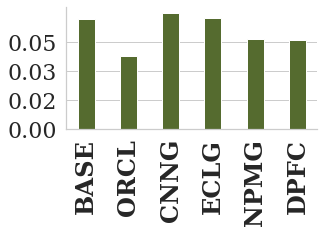

In [85]:
smallplot(ent_NDKL_dic,'darkolivegreen','ent_NDKL.pdf')

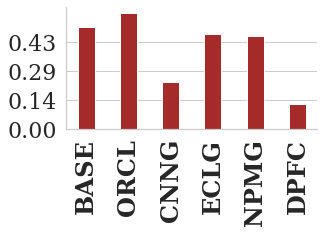

In [86]:
smallplot(ent_ABR_dic,'brown','ent_ABR.pdf')

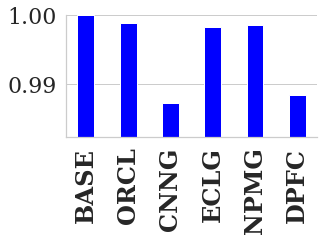

In [87]:
smallplot(ent_NDCG_dic,'blue','ent_NDCG.pdf')

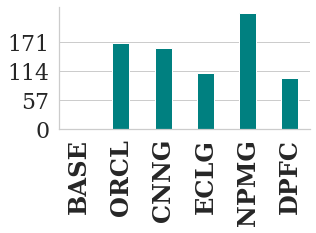

In [88]:
smallplot(ent_rankdelta_dic,'teal','ent_rankdelta.pdf')

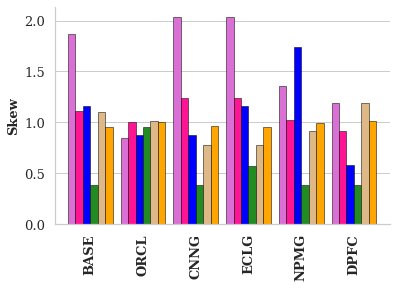

In [89]:
largeplot(ent_skew_dic,"Skew",'ent_skew.pdf')

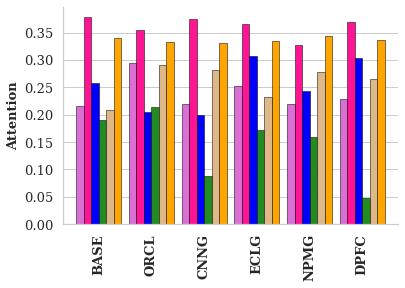

In [90]:
largeplot(ent_att_dic,"Attention",'ent_att.pdf')

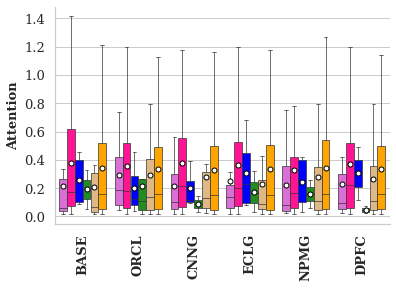

In [91]:
boxplot(ent_att_dic_list,"Attention",'ent_att_list.pdf',log=False)

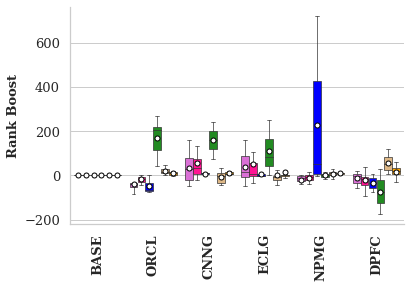

In [92]:
boxplot(ent_rankdelta_dic_list,"Rank Boost",'ent_rankdelta_list.pdf',log=False)

## Equestrians

In [93]:
K = 300

In [94]:
eqdf = pd.read_csv('EQUESTRIANS/equestrian_rankings.csv')

In [95]:
eqdf

,UID,URL,Name,Score,image,gender
0,10011463,https://data.fei.org/Person/Performance.aspx?p...,Steve Guerdat,3627,True,Male
1,10030545,https://data.fei.org/Person/Performance.aspx?p...,Martin Fuchs,3373,True,Male
2,10008871,https://data.fei.org/Person/Performance.aspx?p...,Daniel Deusser,3307,True,Male
3,10002504,https://data.fei.org/Person/Performance.aspx?p...,Peder Fredricson,3021,True,Male
4,10006585,https://data.fei.org/Person/Performance.aspx?p...,Pieter Devos,2935,True,Male
...,...,...,...,...,...,...
1164,10109295,https://data.fei.org/Person/Performance.aspx?p...,Maya Ines Denis Chambon,70,True,Female
1165,10120884,https://data.fei.org/Person/Performance.aspx?p...,Claudia Michel Rodriguez,70,True,Female
1166,10111637,https://data.fei.org/Person/Performance.aspx?p...,Dorothy Douglas,70,True,Female
1167,10178270,https://data.fei.org/Person/Performance.aspx?p...,Lindsey Paton,70,True,Female


In [96]:
eqlist_base = []

In [97]:
eqlabels_maj = json.load(open('EQUESTRIANS/eqlabels_majority.json'))

In [98]:
def getrace_eq(fid):
    if str(fid) not in eqlabels_maj:
        return "err"
    rc = eqlabels_maj[str(fid)]
    if rc == 'White/Caucasian (Non hispanic)':
        return 'White'
    elif rc == 'Asian (Far East, Southeast Asia, and the Indian subcontinent)':
        return 'Asian'
    elif rc == 'Hispanic/Latino':
        return 'Hispanic'
    elif rc == 'Black/African':
        return 'Black'
    else:
        return "err"

In [99]:
#remove groups with less than 1% representation

eqdf['race'] = eqdf['UID'].apply(getrace_eq)
eqdf = eqdf[eqdf['race']!='err']
eqdf['Grp'] = eqdf['race'].astype(str)+'_'+eqdf['gender'].astype(str)
eqdf['Grp'] = eqdf['Grp'].str.strip()
tbr = []
cnt = Counter(eqdf['Grp'])
for g in cnt:
#     if (1/K)/(cnt[g]/len(eqdf))>1.5:
    if (cnt[g]/len(eqdf))<0.01:
        tbr.append(g)
print(tbr)
eqdf = eqdf[~eqdf['Grp'].isin(tbr)]

['Asian_Female', 'Black_Male', 'Hispanic_Female']


/home/avijit/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/avijit/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [100]:
eqrank_base = []
for i,row in eqdf.iterrows():
    g = row['gender'].strip()
    if g in ['Male','Female']:
        eqrank_base.append({'real_rank':i+1,'rank':i+1,'id':str(row['UID']), 'attr':str(row['race'].strip())+'_'+g,
                           'real_attr':str(row['race'].strip())+'_'+g, 'score':int(row['Score'])})

In [101]:
eqrank_deepface = []
temp = {}

f = open('EQUESTRIANS/deepface.txt')
for line in f.readlines():
    items = line.split("\t")
    g = ""
    if items[1]=='Man':
        g = 'Male'
    else:
        g = 'Female'
    r = items[2][:-1]
    race = ""
    if r == "white" or r == "middle eastern":
        race = "White"
    if r == "latino hispanic":
        race = "Hispanic"
    if r == "asian" or r=="indian":
        race = "Asian"
    if r == "black":
        race = "Black"
    ui = items[0].split('/')[-1][:-4]
    temp[ui] = race+"_"+g
f.close()

for t in eqrank_base:
    eqry = t.copy()
    if eqry['id'] in temp:
        eqry['attr'] = temp[eqry['id']]
        eqrank_deepface.append(eqry)

In [102]:
eqgenderize = pd.read_csv('EQUESTRIANS/genderize.csv')
eqgenderizedict = {}
for i,j in zip(eqgenderize.UID,eqgenderize.gender):
    if j in ['male','female']:
        eqgenderizedict[str(i)]=str(j).title()

In [103]:
eqethnicolor = pd.read_csv('EQUESTRIANS/ethnicolor.csv')
eqethnicolordict = {}
for i,j in zip(eqethnicolor.UID,eqethnicolor.race):
    r = j
    if r == 'api':
        r = 'asian'
    eqethnicolordict[str(i)]=str(r).title()

In [104]:
eqethcnn = pd.read_csv('EQUESTRIANS/ethcnn.csv')
eqethcnndict = {}
for i,j in zip(eqethcnn.UID,eqethcnn.ETHCNN_Pred):
    r = j.split('_')[0]
    if r == 'Caucasian':
        r = 'White'
    if r == 'African-American':
        r = 'Black'
    if r!='Native American':
        eqethcnndict[str(i)]=str(r).title()

In [105]:
eqnameprismdict = {}
for i,row in eqdf.iterrows():
    r = getnameprismrace(row['Name'])
    if r == 'API':
        r = 'Asian'
    eqnameprismdict[str(row['UID'])]=r

In [106]:
eqrank_cnn_gen = []

for t in eqrank_base:
    eqry = t.copy()
    if eqry['id'] in eqethcnndict and eqry['id'] in eqgenderizedict:
        eqry['attr'] = eqethcnndict[eqry['id']]+'_'+eqgenderizedict[eqry['id']]
        eqrank_cnn_gen.append(eqry)

In [107]:
eqrank_ethnicolor_gen = []

for t in eqrank_base:
    eqry = t.copy()
    if eqry['id'] in eqethnicolordict and eqry['id'] in eqgenderizedict:
        eqry['attr'] = eqethnicolordict[eqry['id']]+'_'+eqgenderizedict[eqry['id']]
        eqrank_ethnicolor_gen.append(eqry)

In [108]:
eqrank_nameprism_gen = []

for t in eqrank_base:
    eqry = t.copy()
    if eqry['id'] in eqnameprismdict and eqry['id'] in eqgenderizedict:
        eqry['attr'] = eqnameprismdict[eqry['id']]+'_'+eqgenderizedict[eqry['id']]
        eqrank_nameprism_gen.append(eqry)

In [109]:
eqdist = getdist(eqrank_base)
allat = {'Asian_Female',
 'Asian_Male',
 'Black_Female',
 'Black_Male',
 'Hispanic_Female',
 'Hispanic_Male',
 'White_Female',
 'White_Male'}
for a in allat:
    if a not in eqdist:
        eqdist[a] = 0

In [110]:
eq_detconst_oracle = det_const_sort(eqrank_base,eqdist,K)
eq_detconst_deepface = det_const_sort(eqrank_deepface,eqdist,K)
eq_detconst_cnn_gen = det_const_sort(eqrank_cnn_gen,eqdist,K)
eq_detconst_ethnicolor_gen = det_const_sort(eqrank_ethnicolor_gen,eqdist,K)
eq_detconst_nameprism_gen = det_const_sort(eqrank_nameprism_gen,eqdist,K)

In [111]:
method_names = ['BASE','ORCL','CNNG','ECLG','NPMG','DPFC']
eqrankedlists = [eqrank_base,
               eq_detconst_oracle,
               eq_detconst_cnn_gen,
               eq_detconst_ethnicolor_gen,
               eq_detconst_nameprism_gen,
               eq_detconst_deepface]

In [112]:
eq_NDKL_dic = {}
eq_NDCG_dic = {}
eq_skew_dic = {}
eq_att_dic = {}
eq_att_dic_list = {}
eq_ABR_dic = {}
eq_rankdelta_dic = {}
eq_rankdelta_dic_list = {}


for method_name, rankedlist in zip(method_names, eqrankedlists):
    eq_NDKL_dic[method_name] = NDKL(rankedlist[:K], eqdist)
    eq_NDCG_dic[method_name] = NDCG(rankedlist[:K], K)
    eq_skew_dic[method_name] = getskews(rankedlist[:K],eqdist)
    ad = get_attention(rankedlist[:K],dist='geometric',p=0.015)
    eq_att_dic[method_name] = ad
    eq_ABR_dic[method_name] = min(ad.values())/max(ad.values())
    rd = get_rankdelta(rankedlist[:K])
    eq_rankdelta_dic[method_name] = abs(max(rd.values(),key=abs))
    eq_rankdelta_dic_list[method_name] = get_rankdelta_list(rankedlist[:K])
    eq_att_dic_list[method_name] = get_attention_list(rankedlist[:K],dist='geometric',p=0.015)

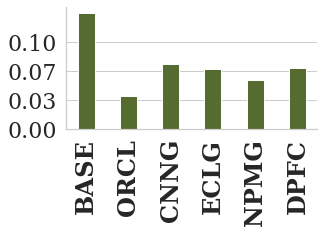

In [113]:
smallplot(eq_NDKL_dic,'darkolivegreen','eq_NDKL.pdf')

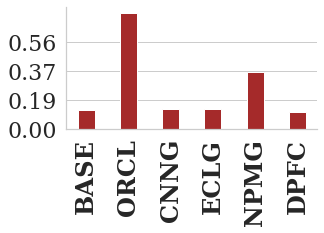

In [114]:
smallplot(eq_ABR_dic,'brown','eq_ABR.pdf')

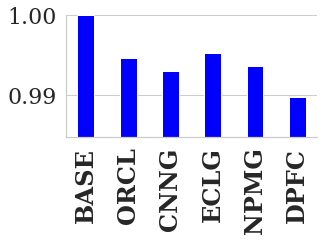

In [115]:
smallplot(eq_NDCG_dic,'blue','eq_NDCG.pdf')

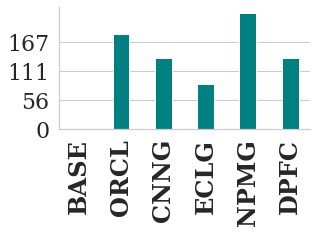

In [116]:
smallplot(eq_rankdelta_dic,'teal','eq_rankdelta.pdf')

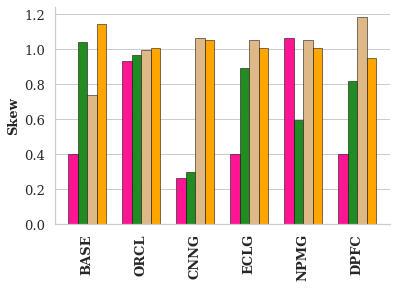

In [117]:
largeplot(eq_skew_dic,"Skew",'eq_skew.pdf')

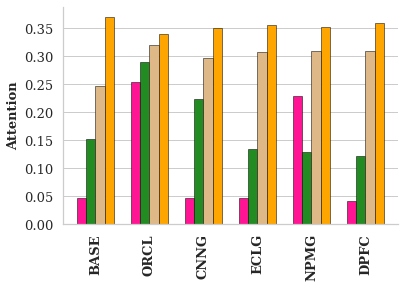

In [118]:
largeplot(eq_att_dic,"Attention",'eq_att.pdf')

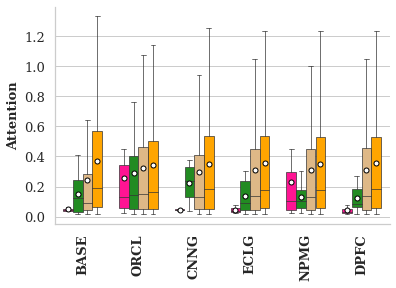

In [119]:
boxplot(eq_att_dic_list,"Attention",'eq_att_list.pdf')

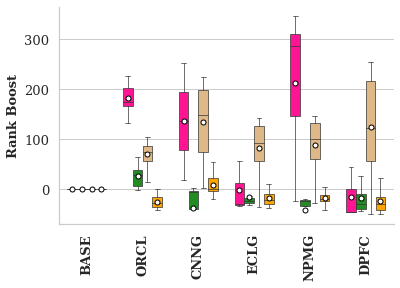

In [120]:
boxplot(eq_rankdelta_dic_list,"Rank Boost",'eq_rankdelta_list.pdf')

In [121]:
len(chessrank_base), len(entrank_base), len(eqrank_base)

(3251, 3308, 1115)

# Group distribution plot for the 3 datasets

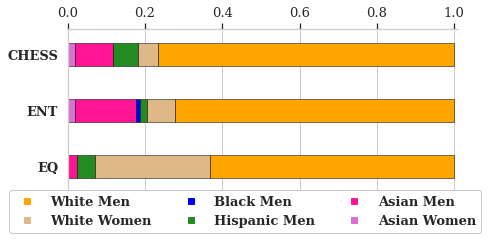

In [122]:
cats = ['White_Male', 'White_Female', 'Black_Male', 'Black_Female', 'Hispanic_Male', 'Hispanic_Female', 'Asian_Male', 'Asian_Female']
color_list = ['orange','burlywood', 'blue', 'deepskyblue', 'forestgreen', 'mediumseagreen', 'deeppink','orchid']
d2c = dict(zip(cats, color_list))


df = pd.DataFrame({'EQ': eqdist, 'ENT': entdist, 'CHESS':chessdist})
df = df.T

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (7,3)
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

#plt.grid(True)
width = 0.4
# if 'eq' in filename:
#     width = 0.7

ax = df.plot(y=sorted(list(df.columns)), width = width, edgecolor='black',
              linewidth=0.5,kind="barh",stacked = 'True', color=[d2c.get(cl) for cl in sorted(list(df.columns))])
ax.set_facecolor('white')
ax.get_legend().remove()
ax.xaxis.grid(True,which='both')
ax.yaxis.grid(False)#,which='both')
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)
ax.set_xlim([0.0,1.01])

ax.xaxis.tick_top()

#ax.set_yscale("log")

plt.yticks(weight='bold')

tickercolors = ['orange','burlywood', 'blue',  'forestgreen',  'deeppink','orchid']
cats = ['White Men', 'White Women', 'Black Men',  'Hispanic Men',  'Asian Men', 'Asian Women']

#colors = ['orange','burlywood', 'forestgreen',  'deeppink','orchid']
#cats = ['White Men', 'White Women',   'Hispanic Men',  'Asian Men', 'Asian Women']
f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", tickercolors[i]) for i in range(len(tickercolors))]
labels = cats
plt.legend(handles, labels, loc=(-0.15,-0.25), framealpha=1,
                    frameon=True,ncol=3,facecolor='white', prop = {'weight':'bold', 'size': 13})

#plt.legend(loc=(1.04,0))
# plt.ylabel('Dataset',size=13,weight='bold')
# plt.xlabel('Fraction of subgroup in dataset',size=13,weight='bold')
plt.xticks(rotation=0)#,weight='bold')
for spine in ('bottom', 'right'): # 'bottom', 'left'): 
    plt.gca().spines[spine].set_visible(False)

plt.savefig('Plots/database_fractions.pdf', bbox_inches='tight')
plt.show()

# Plot to show how different attention functions behave vs rank

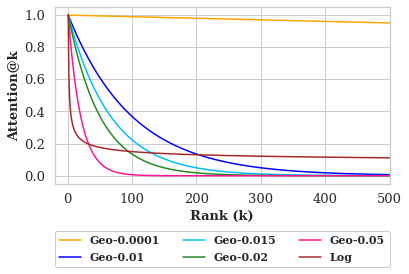

In [123]:
geo_df = {}
geo_df['rank']=[]
geo_df['value']=[]
geo_df['type'] = []


plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 1
plt.rcParams['grid.color'] = "#cccccc"
plt.rcParams['axes.edgecolor'] = "#cccccc"
plt.rcParams["figure.figsize"] = (6,3.25)
plt.rcParams["font.family"] = 'DejaVu Serif'
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

prob_vals = [0.0001, 0.01, 0.015, 0.02, 0.05, 'log']

for p in prob_vals:
    for i in range(1,1000):
        if p!='log':
            init_val = 1/p
            geo_att_i = init_val*((1-p)**(i-1))*p    
            geo_df['rank'].append(i)
            geo_df['value'].append(geo_att_i)
            geo_df['type'].append('geo-'+str(p))
        else:
            log_att_i = 1/(math.log2(1+i))
            geo_df['rank'].append(i)
            geo_df['value'].append(log_att_i)
            geo_df['type'].append('log')

geo_df = pd.DataFrame(geo_df)
color_list2 = ['orange', 'blue', 'deepskyblue', 'forestgreen', 'deeppink','brown']

sns.lineplot(data= geo_df, x= 'rank', y='value', hue='type', palette=color_list2)

ax = plt.gca()
ax.xaxis.grid(True,which='both')
ax.yaxis.grid(True,which='both')



ax.set_facecolor('white')
ax.tick_params(axis='y', which='both',labelsize=13)
ax.tick_params(axis='x', which='both',labelsize=13)
ax.xaxis.set_minor_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_xlim([-20,500])


plt.ylabel('Attention@k',fontsize=13,weight='bold')
plt.xlabel('Rank (k)', fontsize =13,weight='bold')


legend_list = ['Geo-'+str(i) if i!='log' else 'Log'  for i in prob_vals]
plt.legend(legend_list,
           facecolor='white', framealpha=1,
           bbox_to_anchor=(0,-0.47,1,0.3), loc="lower left",mode="expand", borderaxespad=0, ncol=3,
           prop={'size': 11, 'weight':'bold'})
plt.savefig('Plots/geometric_log_ratio.pdf', bbox_inches='tight')